# A demonstration of model performance uncertainty as a function of the data set size
***

In [25]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,recall_score,auc,accuracy_score,roc_curve
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

***
## Define custorm transformer and functions

In [2]:
class AttributeSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, dataframe, y=None):
        return self
    
    def transform(self, dataframe):
        return dataframe[self.attribute_names]

In [ ]:
def balance_dataset(data,target):
    
    class1 = data[data[target]==1]
    class0 = data[data[target]==0]

    class_imbalance = class1.shape[0]-class0.shape[0]

    if class_imbalance<0:
        drop_indices = np.random.choice(class0.index, np.absolute(class_imbalance), replace=False)
        class0_subset = class0.drop(drop_indices)
        data = pd.concat((class1,class0_subset), ignore_index = True)
        print('New shape: {}'.format(data.shape[0]))
        
    elif class_imbalance>0:
        drop_indices = np.random.choice(class1.index, np.absolute(class_imbalance), replace=False)
        class1_subset = class1.drop(drop_indices)
        data = pd.concat((class0,class1_subset), ignore_index = True)
        print('New shape: {}'.format(data.shape[0]))
    
    else:
        return data
        
    return data 

In [ ]:
def reduce_dataset_size(data,target_size,target):
        n_drop = data.shape[0] - target_size
        if n_drop%2!=0:
            n_drop+=1
            
        class1 = data[data[target]==1]
        class0 = data[data[target]==0]
        
        drop_indices0 = np.random.choice(class0.index, int(n_drop/2), replace=False)
        class0_subset = class0.drop(drop_indices0)
        drop_indices1 = np.random.choice(class1.index, int(n_drop/2), replace=False)
        class1_subset = class1.drop(drop_indices1)
        data = pd.concat((class0_subset,class1_subset), ignore_index = True)
        print('New shape: {}'.format(data.shape[0]))
        
        return data.reset_index(drop=True)

In [ ]:
def evaluate_model(data,pipeline,features,target,test_size=0.3):
    
    #Train-test split with no random seed, so different
    #sets are generated each time function is called. 
    X, y = data[features], data[target]
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size)
    for train_index, test_index in split.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

    #train model, fit method overwrites training on each call
    pipeline.fit(X_train,y_train)
    
    #evaluate on test set
    test_predictions = pipeline.predict(X_test)
    recall = recall_score(y_test,test_predictions)
    precision = precision_score(y_test,test_predictions)
    acc = accuracy_score(y_test,test_predictions)
    
    #calculate fpr and tpr for each threshold to get an AUROC
    test_probabilities = pipeline.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test,test_probabilities,pos_label=1,drop_intermediate=True)
    auroc = auc(fpr,tpr)
    
    return recall, precision, acc, auroc

***
## Load and explore the data

In [3]:
path_ = 'https://s3-eu-west-1.amazonaws.com/fellowship-teaching-materials/data-practical/adult.csv' 
df = pd.read_csv(path_, header='infer', index_col=None)


In [4]:
print(df.head())
df.income.unique()

   age          workclass  fnlwgt   education  educationNum  \
0   39          State-gov   77516   Bachelors            13   
1   50   Self-emp-not-inc   83311   Bachelors            13   
2   38            Private  215646     HS-grad             9   
3   53            Private  234721        11th             7   
4   28            Private  338409   Bachelors            13   

         maritalStatus          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capitalGain  capitalLoss  hoursPerWeek   nativeCountry  income  
0         2174            0            40   United-States   <=50K  
1         

array([' <=50K', ' >50K'], dtype=object)

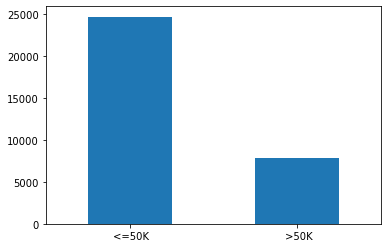

In [5]:
df.income.value_counts().plot(kind='bar')
plt.xticks(rotation=360);

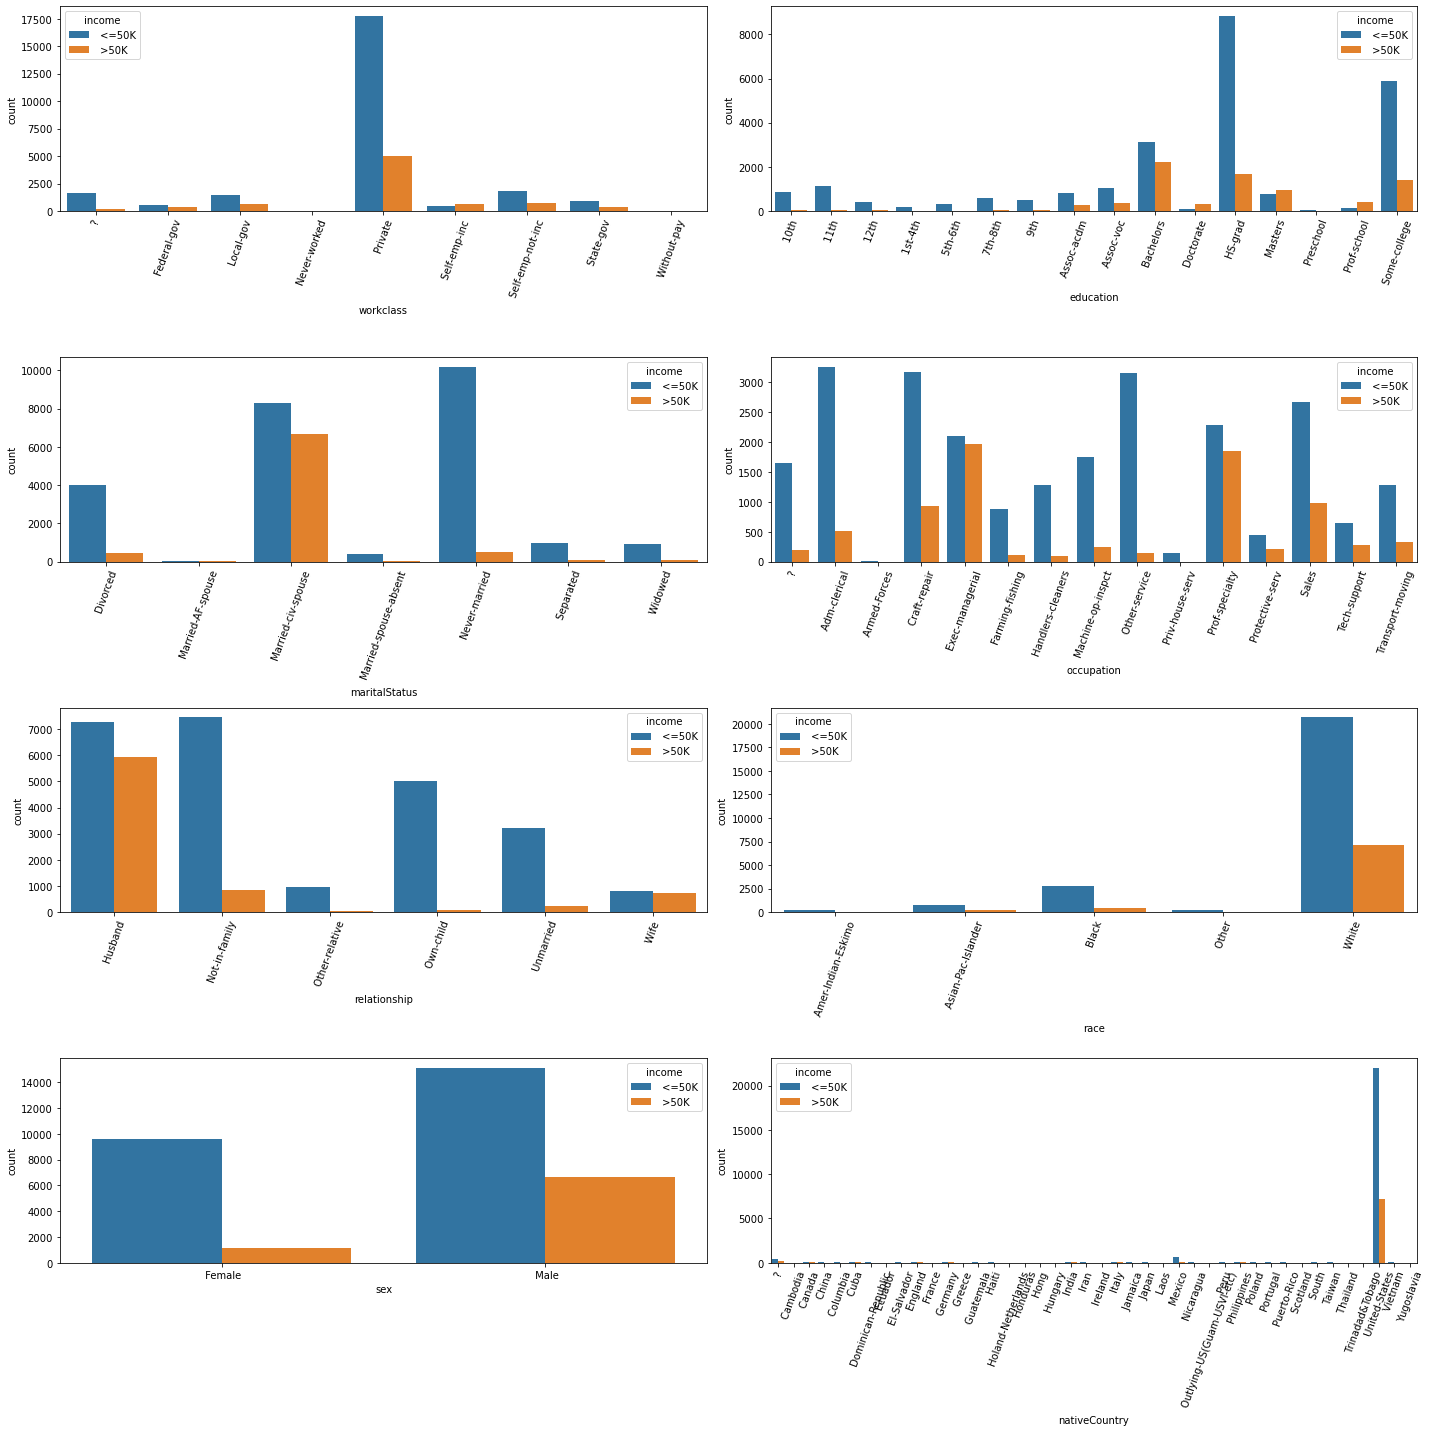

In [8]:
# plot bar charts of you categorical variables
# It might be useful to compare the values of each category given the target variable (income)
cat_cols = ['workclass', 'education', 'maritalStatus', 'occupation', 'relationship', 'race', 'sex', 'nativeCountry']

# set as categories
for cat in cat_cols:
    df[cat] = df[cat].astype('category') 
    
fig, axes = plt.subplots(ncols=2,nrows=4, figsize=[20,20])
axes = np.ravel(axes)

for idx, ax in enumerate(axes):
    sns.countplot(x=cat_cols[idx], hue="income", data=df, ax=ax)
    if cat_cols[idx] != 'sex':
        ax.xaxis.set_tick_params(rotation=70)
plt.tight_layout()

In [9]:
df.corr()

,age,fnlwgt,educationNum,capitalGain,capitalLoss,hoursPerWeek
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768
educationNum,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123
capitalGain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409
capitalLoss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256
hoursPerWeek,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000


***
## Preparing dataset

In [10]:
# keep a subset of columns
cat_cols = ['relationship', 'education','sex']
numerical_cols = ['age', 'hoursPerWeek']
target = ['income']
selected_features = cat_cols+numerical_cols+target

data = df.copy()
data  = data[selected_features]
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)
data = pd.get_dummies(data, drop_first=True)#one-hot encode target variable 
print(data.head())
data.shape

   age  hoursPerWeek  relationship_ Not-in-family  \
0   39            40                            1   
1   50            13                            0   
2   38            40                            1   
3   53            40                            0   
4   28            40                            0   

   relationship_ Other-relative  relationship_ Own-child  \
0                             0                        0   
1                             0                        0   
2                             0                        0   
3                             0                        0   
4                             0                        0   

   relationship_ Unmarried  relationship_ Wife  education_ 11th  \
0                        0                   0                0   
1                        0                   0                0   
2                        0                   0                0   
3                        0                   0      

(15591, 24)

New shape: 7624


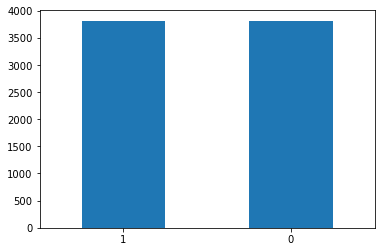

In [11]:
#balance and resize dataset
data = balance_dataset(data,'income_ >50K')#balance classes

data['income_ >50K'].value_counts().plot(kind='bar')
plt.xticks(rotation=360);

***
## Train and evaluate model

***
## Calculate some histrograms for 100 datapoints

In [27]:
#define features
numerical_cols = list(data.columns)[:2]
cat_cols = list(data.columns)[2:-1]
features = list(data.columns)[:-1]
target = list(data.columns)[-1]
#define pipeline
text_pipeline = Pipeline([('selec',AttributeSelector(cat_cols))])
num_pipeline  = Pipeline([('selec',AttributeSelector(numerical_cols)),('imput',SimpleImputer())])
transform_pipeline = FeatureUnion([('text_pipe',text_pipeline),('num_pipe',num_pipeline)])
pipeline = Pipeline([('trans',transform_pipeline),('clf',LogisticRegression(max_iter=1000))])

In [29]:
data_1000 = reduce_dataset_size(data,1000,'income_ >50K')
n_splits=100
Recall = np.zeros(n_splits)
Precision = np.zeros(n_splits)
Accuracy = np.zeros(n_splits)
AUC = np.zeros(n_splits)
for j in range(n_splits):
    recall, precision, auroc, acc = evaluate_model(data_1000,pipeline,features,target)
    Recall[j] = recall
    Precision[j] = precision
    Accuracy[j] = acc
    AUC[j] = auroc

New shape: 1000


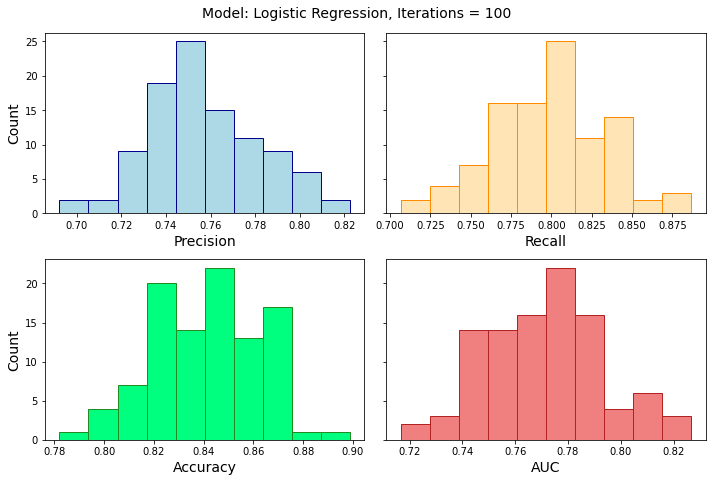

In [637]:
fig,axes = plt.subplots(2,2,figsize=(10,7),sharey='row')
plt.suptitle('Model: Logistic Regression, Iterations = 100',fontsize=14)
axes[0,0].hist(Precision,facecolor='lightblue',ec='darkblue')
axes[0,1].hist(Recall,facecolor='moccasin',ec='darkorange')
axes[1,0].hist(Accuracy,facecolor='springgreen',ec='forestgreen')
axes[1,1].hist(AUC,facecolor='lightcoral',ec='firebrick')

axes[0,0].set_xlabel('Precision',fontsize=14)
axes[0,1].set_xlabel('Recall',fontsize=14)
axes[1,0].set_xlabel('Accuracy',fontsize=14)
axes[1,1].set_xlabel('AUC',fontsize=14)
axes[0,0].set_ylabel('Count',fontsize=14)
axes[1,0].set_ylabel('Count',fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('sampling_distributions.png',dpi=300)

In [638]:
print('Mean accuracy is {:.2f}'.format(np.mean(Accuracy)))
print('standard deviation of accuracy is {:.3f}'.format(np.std(Accuracy)))


Mean accuracy is 0.84
standard deviation of accuracy is 0.021


***
# Loop over all data set sizes and 

In [583]:
data_set_sizes = [7000,5000,3000,1000,500,100,50]
data = data #start with entire dataset

STD_Recall = np.zeros(len(data_set_sizes))
STD_Precision = np.zeros(len(data_set_sizes))
STD_Accuracy = np.zeros(len(data_set_sizes))
STD_AUC = np.zeros(len(data_set_sizes))

MEAN_Recall = np.zeros(len(data_set_sizes))
MEAN_Precision = np.zeros(len(data_set_sizes))
MEAN_Accuracy = np.zeros(len(data_set_sizes))
MEAN_AUC = np.zeros(len(data_set_sizes))

n_splits = 100#number of train-test splits

for i,size in enumerate(data_set_sizes):
    print(size)
    data = reduce_dataset_size(data,size,'income_ >50K')
    
    for j in range(n_splits):
        recall, precision, auroc, acc = evaluate_model(data,pipeline,features,target)
        Recall[j] = recall
        Precision[j] = precision
        Accuracy[j] = acc
        AUC[j] = auroc
        
    #collect uncertainties 
    STD_Recall[i] = np.std(Recall)
    STD_Precision[i] = np.std(Precision)
    STD_Accuracy[i] = np.std(Accuracy)
    STD_AUC[i] = np.std(AUC)
    
    #collect mean values
    MEAN_Recall[i] = np.mean(Recall)
    MEAN_Precision[i] = np.mean(Precision)
    MEAN_Accuracy[i] = np.mean(Accuracy)
    MEAN_AUC[i] = np.mean(AUC)
    


7000
New shape: 7000
5000
New shape: 5000
3000
New shape: 3000
1000
New shape: 1000
500
New shape: 500
100
New shape: 100
50
New shape: 50


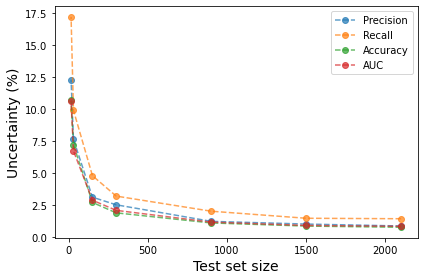

In [641]:
fig = plt.figure()
x = 0.3*np.asarray(data_set_sizes)
plt.plot(x,100*STD_Precision,linestyle='--',marker='o',alpha=0.7,label='Precision')
plt.plot(x,100*STD_Recall,linestyle='--',marker='o',alpha=0.7,label='Recall')
plt.plot(x,100*STD_Accuracy,linestyle='--',marker='o',alpha=0.7,label='Accuracy')
plt.plot(x,100*STD_AUC,linestyle='--',marker='o',alpha=0.7,label='AUC')
plt.legend()
plt.xlabel('Test set size',fontsize=14)
plt.ylabel('Uncertainty (%)',fontsize=14)
plt.tight_layout()
plt.savefig('Uncertainty_datasize.png',dpi=300)
plt.show()